In [1]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm, TwoMaterialFilm, EqOTFilm
from design import BaseDesign
from spectrum import BaseSpectrum, Spectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_reflection_design, make_three_line_filter_design
from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle

In [36]:
# impact of hyperpram on convergence
target = make_edgefilter_design().target_specs
max_step = 300

def exp(layer_ot, n_size, no_gd=False, film_gd=False):
    np.random.seed((layer_ot + 255) * n_size % 7)
    n = np.zeros(n_size) + 2 # 1.5 to 2.5, init ot dif from final ot by: 1/4
    film = EqOTFilm(n, layer_ot * n_size, 1.5)
    if no_gd:
        return film
    optimizer = AdamFreeFormOptimizer(
        film, 
        target, 
        max_steps=max_step, 
        alpha=0.01, 
        record=True, 
        show=False, 
        wl_batch_size=500, 
        n_min=1.5, 
        n_max=2.5
    )
    films, losses = optimizer()
    if film_gd:
        return film
    return losses

layer_ots = [1, 10, 100]
n_sizes = [1000]

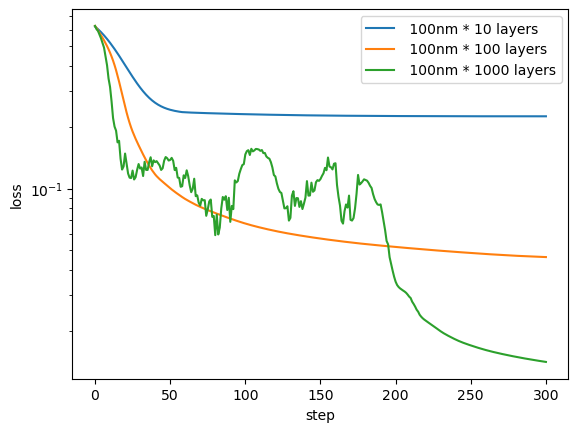

In [37]:

fig, ax = plt.subplots(1, 1)
for layer_ot in layer_ots:
    for n_size in n_sizes:
        ax.plot(np.arange(max_step + 1), exp(layer_ot, n_size), label=f'{layer_ot: .0f}nm * {n_size} layers')
        ax.set_xlabel('step')
        ax.set_ylabel('loss')
        ax.set_yscale('log')

ax.legend()

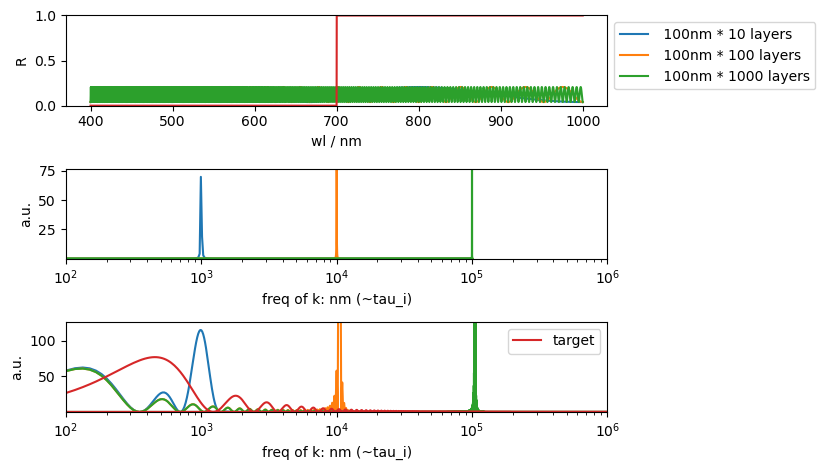

In [39]:
N = 10000

def plot_FT(film: BaseFilm, ax):
    wls = np.linspace(1 / 40, 1 / 3000, N)
    wls = 1 / wls

    R = film.get_spec(0., wls).get_R()
    T = film.get_spec(0., wls).get_T()
    Q = R / T
    x = np.fft.fftfreq(wls.shape[0], 2 * (1 / wls[0] - 1 / wls[-1]) / wls.shape[0])
    y = np.abs(np.fft.fft(Q)) ** 2
    ax.plot(x, x * y / y.sum())
    # ax.set_xlim(None, None)
    ax.set_ylabel('a.u.')
    ax.set_xlabel('freq of k: nm (~tau_i)')

    ax.set_xscale('log')
    ax.set_xlim(1e2, 1e6)
    ax.set_ylim(1e-6, None)

def plot_FT_masked(spec, ax):

    wls_o_i = 1 / spec.WLS
    m = 10
    wls_pad_left = 1 / np.linspace(wls_o_i[0], wls_o_i[0] + m * (wls_o_i[0] - wls_o_i[-1]), m * N)
    wls_pad_right = 1 / np.linspace(wls_o_i[-1] - m * (wls_o_i[0] - wls_o_i[-1]), wls_o_i[-1], m * N)
    wls = np.hstack((wls_pad_left, spec.WLS, wls_pad_right))

    Q = spec.get_R() / spec.get_T()
    Q = np.hstack((np.zeros_like(wls_pad_left), Q, np.zeros_like(wls_pad_right)))
    
    x = np.fft.fftfreq(wls.shape[0], 2 * (1 / wls[0] - 1 / wls[-1]) / wls.shape[0])
    y = np.abs(np.fft.fft(Q)) ** 2
    y = y / y.sum()

    s = ax.plot(x / 20, y * x) # \int f(x) y dlnx  = 1 and \int y dx = 1 -> f(x) \propto 1 / x
    ax.set_ylabel('a.u.')
    ax.set_xlabel('freq of k: nm (~tau_i)')

    ax.set_xscale('log')
    ax.set_xlim(1e2, 1e6)
    # ax.set_yscale('log')
    ax.set_ylim(1e-6, None)
    return s

def get_edge_filter_spec(wls):
    R = (wls > 700.) * 1 + 0
    T = 1 - R
    return Spectrum(0., wls, R, (T + 1e-5))

def get_triband_filter_spec(wls):
    R = (440. > wls > 400. or 500. > wls > 460. or 630. > wls > 520. or 700. > wls > 650.) * 1 + 0
    T = 1 - R
    return Spectrum(0., wls, R, (T + 1e-5))

wls = np.linspace(400, 1000, N)
wls_inv_int = 1 / np.linspace(1 / 1000, 1 / 400, N)

fig, (ax, ax_ft, ax_ft_mask) = plt.subplots(3, 1)
for layer_ot in layer_ots:
    for n_size in n_sizes:
        film = exp(layer_ot, n_size, no_gd=True)
        # spec
        ax.plot(wls, film.get_spec(0., wls).get_R(), label=f'{layer_ot: .0f}nm * {n_size} layers')
        ax.set_xlabel('wl / nm')
        ax.set_ylabel('R')
        ax.set_ylim(0, 1)
        # FT of spec
        plot_FT(film, ax_ft) # full
        plot_FT_masked(film.get_spec(0., wls_inv_int), ax_ft_mask) # blurred

ax.plot(get_edge_filter_spec(wls).WLS, get_edge_filter_spec(wls).get_R())
s = plot_FT_masked(get_edge_filter_spec(wls_inv_int), ax_ft_mask)

s[0].set_label('target')
s[0].set_ls('-')
ax_ft_mask.legend()

ax.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
# fig.savefig('./results/converge/FT_of_spec_const_init.png', dpi=300)